In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
# access the file through indexing
seq_len = 8
pre_len = 4

def get_ts(c_sample, tstamp_ix):
    num_frames = seq_len + pre_len
    c_sample = c_sample[tstamp_ix: tstamp_ix + num_frames, :, :]
    input = c_sample[:seq_len] # [self.seq_len, #nodes, #attributes]
    pred = c_sample[seq_len : seq_len+pre_len] # [self.pre_len, #nodes, #attributes]

    # Get speed as prediction
    x = input[...,1]
    y = pred[...,1]

    return x,y

def get_train_data(file_path):
    c_sample = h5py.File(file_path,'r')['data']
    x_all, y_all = [], []
    for i in range(96-seq_len-pre_len):
        x, y = get_ts(c_sample, i)
        x_all.append(x)
        y_all.append(y)

    return np.array(x_all), np.array(y_all)

def get_daily_series(file_path):
    c_sample = h5py.File(file_path,'r')['data']
    return c_sample[...,1]

def get_id(city, identifiers):
    f = root / "adj" / city / "road_filtered_with_id.parquet"
    identifier_table = pd.read_parquet(f).sort_values(by="road_index", ascending=True)
    # Extract identifiers
    id_arr = []
    for id in identifiers:
        assert id in identifier_table.columns, f"ID [{id}] does not exist in identifier table [{file_path}]"
        id_arr.append(identifier_table[id].values)
        print(f"MultiIDDataset - label: {id} - unique num: ", np.unique(id_arr[-1]).shape[0])



    # Overlay identifiers
    id_arr = np.stack(id_arr, axis=-1) #(num_node, num_identifiers)
    # print("MultiIDDataset id_arr.shape ", id_arr.shape)
    # Get unique
    uid, identifier_labels = np.unique(id_arr, axis=0, return_inverse=True)
    # print("MultiIDDataset identifier_labels.shape ", identifier_labels.shape)
    print("MultiIDDataset overlaid label - unique num: ", uid.shape[0])
    return identifier_labels #(num_node)
    

In [3]:
# Dimension deduction to use KDE to find the mapping between x and y

from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA

def PCA_process(x):
    pca = PCA()
    pca.fit(x)
    data_pca = pca.transform(x)
    print("Explained_variance ", pca.explained_variance_ratio_)
    return data_pca

def dim_reduct(x):
    ts, size, num_nodes = x.shape
    # merge ts and graph dim
    x = np.swapaxes(x, 1, 2).reshape(-1, size)
    
    scalar = StandardScaler().fit(x)
    # scale to the same distribution
    scaled_x = scalar.transform(x)
    
    # pca
    x_de = PCA_process(scaled_x)
    
    x_de = scalar.inverse_transform(x_de)
    
    return x_de

In [4]:
root = Path("/Users/aaaje/Documents/ETH_WORK/thesis/data/t4f2022")

city = "melbourne"
d = "2020-06-01"

data_file = root / "speed_train_daily" / city / f"speed_filtered_{d}.h5"

x,y = get_train_data(data_file)

print(f"x.shape {x.shape}, y.shape {y.shape}")

road = get_id(city, ["id_highway"])

x.shape (84, 8, 350), y.shape (84, 4, 350)
MultiIDDataset - label: id_highway - unique num:  1
MultiIDDataset overlaid label - unique num:  1


In [5]:
# Get daily time series
days = ['2020-06-01','2020-06-02','2020-06-03','2020-06-04','2020-06-05','2020-06-06','2020-06-07']
daily_all = []
for d in days:
    dfile = root / "speed_train_daily" / city / f"speed_filtered_{d}.h5"
    daily_all.append(get_daily_series(dfile))

daily_all = np.array(daily_all)
daily_all.shape

(7, 96, 350)

In [33]:
# ARMA model to fit real time series
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
# Select a node
node = 155
ts = daily_all[...,node].reshape(-1)

model = ARIMA(ts, order=(2,1,2))
results = model.fit()

print("AR:", results.arparams)
print("MA:", results.maparams)

AR: [-0.62046261  0.31828717]
MA: [ 0.05014831 -0.92667019]


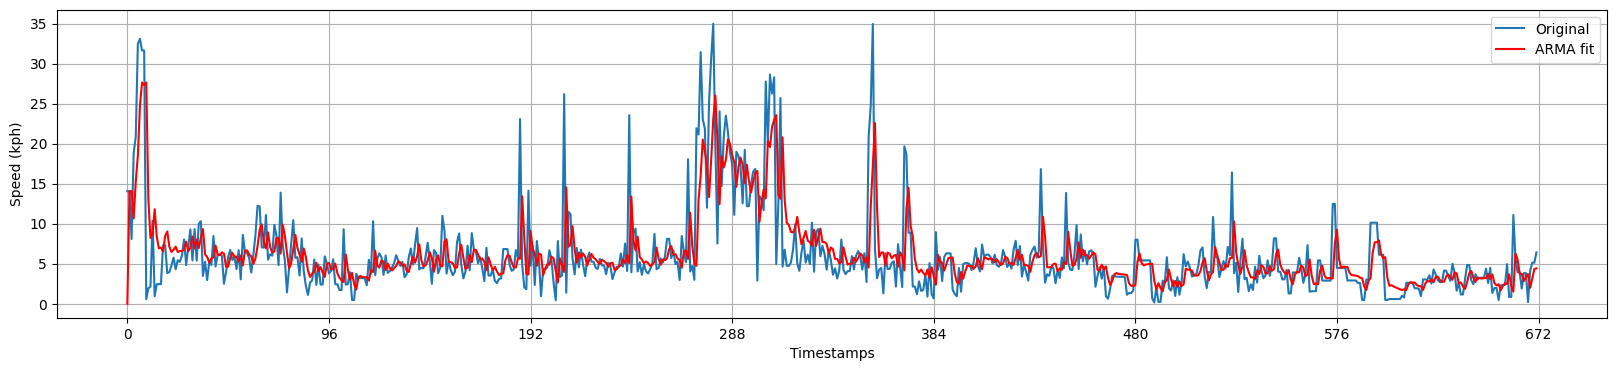

In [28]:
# plot arma result
fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(ts, label="Original")
ax.plot(results.fittedvalues, color='red', label="ARMA fit")
ax.set_xticks(np.arange(0,96*7+1,96))
ax.grid()
ax.set_xlabel("Timestamps")
ax.set_ylabel("Speed (kph)")
ax.legend()

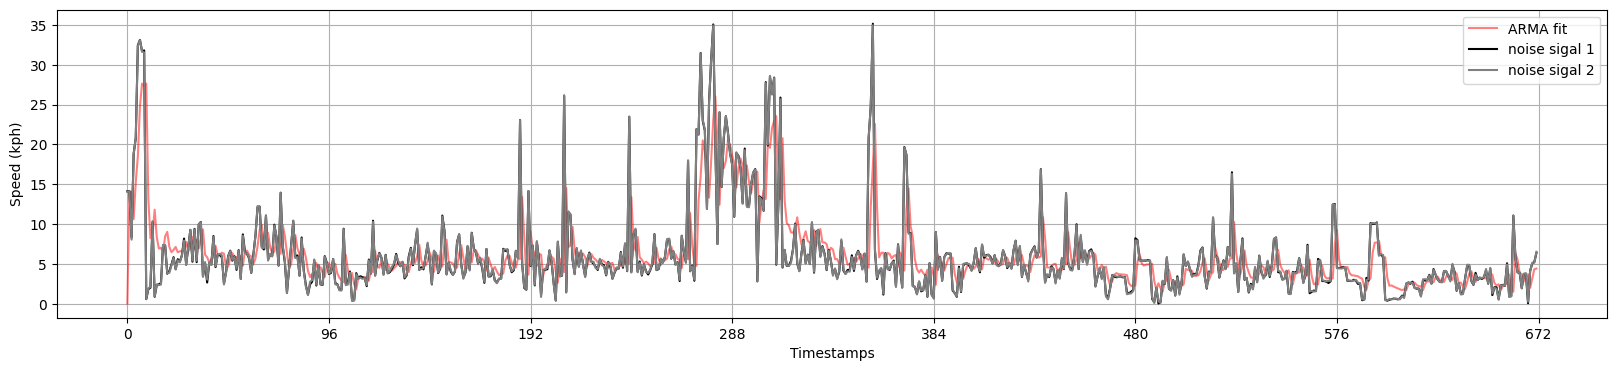

In [29]:
# add random noise
rng = np.random.default_rng()
tsn1 = ts + rng.standard_normal(len(ts)) * 0.1
tsn2 = ts + rng.standard_normal(len(ts)) * 0.05

fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(results.fittedvalues, color='red', alpha=0.5, label="ARMA fit")

ax.plot(tsn1, color="black", label='noise sigal 1')
ax.plot(tsn2, color="grey", label='noise sigal 2')

ax.set_xticks(np.arange(0,96*7+1,96))
ax.grid()
ax.set_xlabel("Timestamps")
ax.set_ylabel("Speed (kph)")
ax.legend()

In [30]:
# Temporal Shift by IIR
from scipy import signal
from sklearn.preprocessing import normalize
def simulate_ar(ar, ma, eta):
    d = signal.lfilter(np.r_[1, ar], np.r_[1, -ma], eta)
    return d


seed = 23  # random seed
np.random.seed(seed)

baseline = tsn1

ar = np.array([0.05,0.1])
ma = np.array([-0.01, 0.1])

for idx in np.arange(1,7):
    ts_ar = np.concatenate((baseline[:96*idx],simulate_ar(ar, ma, baseline[96*idx:])), axis=0)
    baseline = ts_ar

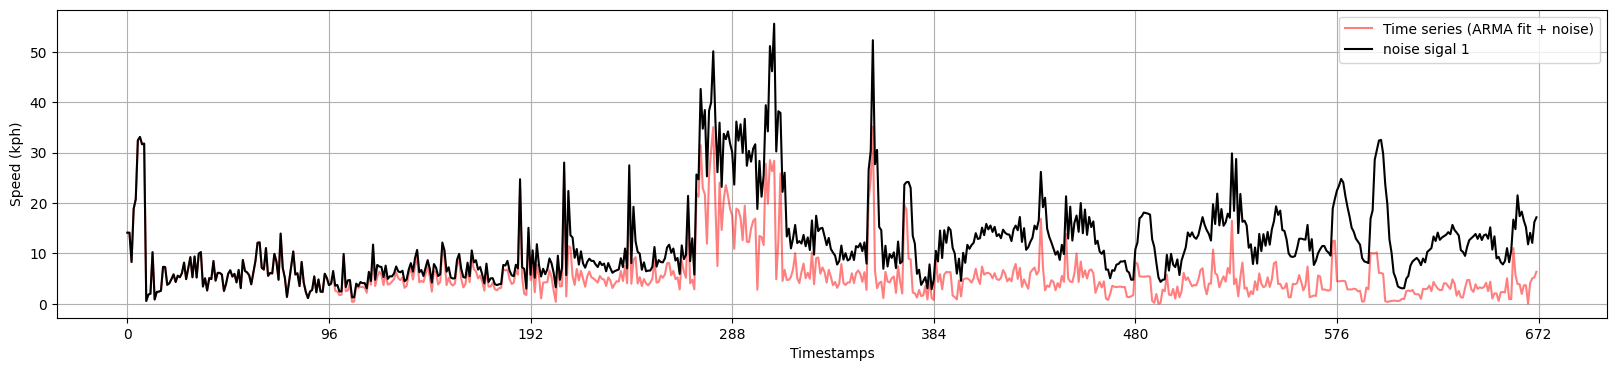

In [31]:
fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(tsn1, color='red', alpha=0.5, label="Time series (ARMA fit + noise)")

ax.plot(ts_ar, color="black", label='noise sigal 1')


ax.set_xticks(np.arange(0,96*7+1,96))
ax.grid()
ax.set_xlabel("Timestamps")
ax.set_ylabel("Speed (kph)")
ax.legend()

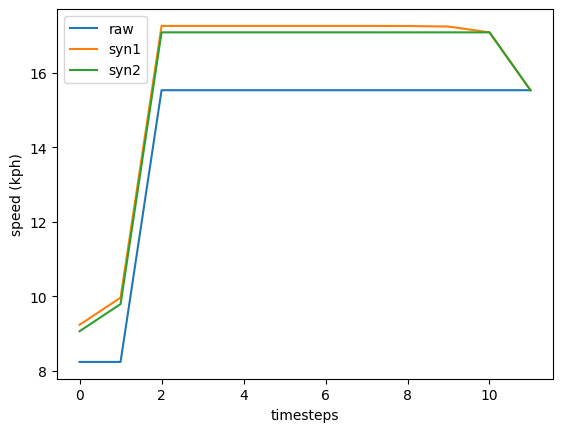

In [31]:
# Synthetic data
from scipy import signal
from sklearn.preprocessing import normalize

x_ = np.concatenate((x,y), axis=1)

x_norm = x_ / np.linalg.norm(x_.reshape(-1))

def simulate_ar(seed, n, ar, ma, eta):
    d = signal.lfilter(np.r_[1, ar], np.r_[1, -ma], eta)
    d = d[::-1]
    return d

seed = 23  # random seed
n = x_.shape[1]    # length of sequence
eta = np.random.normal(size=(n,)) * 0.1 + 1

np.random.seed(seed)

input_seq = x_[0,:,100][::-1]

# ARMA parameters
# ar = np.array([0.0, 0.0, 0.0, 0.05, 0.1, 0.0,  0.2, 0.0])
# ma = np.array([0.0, 0.0, 0.0, 0.05, 0.1, 0.0,  0.2, 0.0])
ar = np.array([0.0, 0.0, 0.0,  0.0, 0.0])
ma = np.array([0.1, 0.0, 0.0,  0.0, 0.0])

xy1 = simulate_ar(seed, n, ar, ma, input_seq)

# ARMA parameters
ar = np.array([0.1, 0.0, 0.0,  0.0, 0.0])
ma = np.array([0.0, 0.0, 0.0,  0.0, 0.0])

xy2 = simulate_ar(seed, n, ar, ma, input_seq)

plt.plot(input_seq[::-1], label="raw")
plt.plot(xy1, label="syn1")
plt.plot(xy2, label="syn2")
plt.xlabel("timesteps")
plt.ylabel("speed (kph)")
plt.legend()

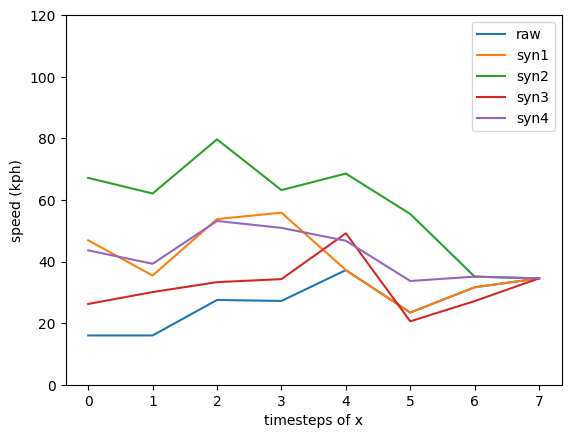

In [53]:
# Synthetic data
from scipy import signal
from sklearn.preprocessing import normalize

x_ = x

x_norm = x_ / np.linalg.norm(x_.reshape(-1))

def simulate_ar(seed, n, ar, ma, eta):
    d = signal.lfilter(np.r_[1, ma], np.r_[1, -ar], eta)
    d = d[::-1]
    return d

seed = 23  # random seed
n = x_.shape[1]    # length of sequence
eta = np.random.normal(size=(n,)) * 0.1 + 1

np.random.seed(seed)

node_idx = 3
input_seq = x_[0,:,node_idx][::-1]

# ARMA parameters
ar = np.array([0.0, 0.0, 0.0,  0.33, 0.0])
ma = np.array([0.0, 0.0, 0.0,  0.5, 0.0])

xy1 = simulate_ar(seed, n, ar, ma, input_seq)

# ARMA parameters
ar = np.array([ 0.05,  0.33, 0.2])
ma = np.array([ 0.05,  0.5, -0.2])

xy2 = simulate_ar(seed, n, ar, ma, input_seq)

# ARMA parameters
ar = np.array([ -0.05,  -0.02, 0.2])
ma = np.array([ -0.08,  0.05, 0.2])

xy3 = simulate_ar(seed, n, ar, ma, input_seq)

ar = np.array([ 0.05, 0.1, 0.0,  0.2, 0.0])
ma = np.array([ 0.05, 0.1, 0.0,  0.2, 0.0])
xy4 = simulate_ar(seed, n, ar, ma, input_seq)

plt.plot(input_seq[::-1], label="raw")
plt.plot(xy1, label="syn1")
plt.plot(xy2, label="syn2")
plt.plot(xy3, label="syn3")
plt.plot(xy4, label="syn4")
plt.ylim(0,120)
plt.xlabel("timesteps of x")
plt.ylabel("speed (kph)")
plt.legend()
plt.savefig(f"./fig/synthetic_{city}_{node_idx}.png", bbox_inches="tight")

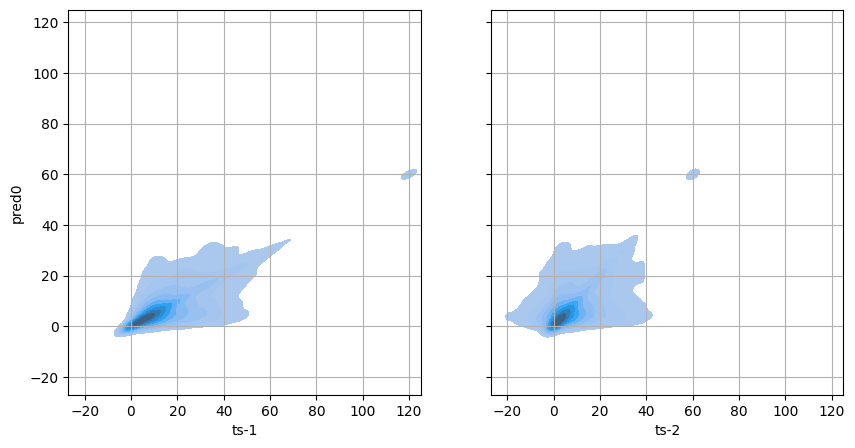

In [52]:
# KDE between most recent ts in x and first timestamp in y
r_de = np.repeat(road[:,np.newaxis], 84, axis=1).transpose().reshape(-1)
x_f = np.swapaxes(xy_sim[:,:8,:], 1, 2).reshape(-1, seq_len)
y_f = np.swapaxes(xy_sim[:,8:,:], 1, 2).reshape(-1, pre_len)
df = pd.DataFrame(data=np.stack((x_f[:,-1],x_f[:,-2], y_f[:,0], r_de), axis=1), columns=["ts-1","ts-2","pred0","id"])
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.kdeplot(
    data=df, x="ts-1", y="pred0",
#     hue="id",
    fill=True,
    ax = axes[0]
)
sns.kdeplot(
    data=df, x="ts-2", y="pred0",
#     hue="id",
    fill=True,
    ax = axes[1]
)
for ax in axes:
    ax.set_xlim(-27,125)
    ax.set_ylim(-27,125)
    ax.grid()

plt.savefig(f"./fig/kde_{city}_{d}_nondr_sim.png", bbox_inches="tight")
plt.show()

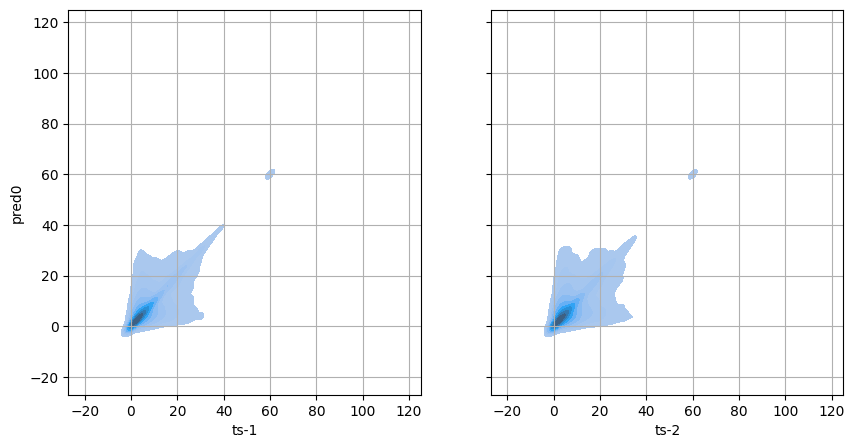

In [28]:
# KDE between most recent ts in x and first timestamp in y
r_de = np.repeat(road[:,np.newaxis], 84, axis=1).transpose().reshape(-1)
x_f = np.swapaxes(x, 1, 2).reshape(-1, seq_len)
y_f = np.swapaxes(y, 1, 2).reshape(-1, pre_len)
df = pd.DataFrame(data=np.stack((x_f[:,-1],x_f[:,-2], y_f[:,0], r_de), axis=1), columns=["ts-1","ts-2","pred0","id"])
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.kdeplot(
    data=df, x="ts-1", y="pred0",
#     hue="id",
    fill=True,
    ax = axes[0]
)
sns.kdeplot(
    data=df, x="ts-2", y="pred0",
#     hue="id",
    fill=True,
    ax = axes[1]
)
for ax in axes:
    ax.set_xlim(-27,125)
    ax.set_ylim(-27,125)
    ax.grid()

plt.savefig(f"./fig/kde_{city}_{d}_nondr.png", bbox_inches="tight")
plt.show()

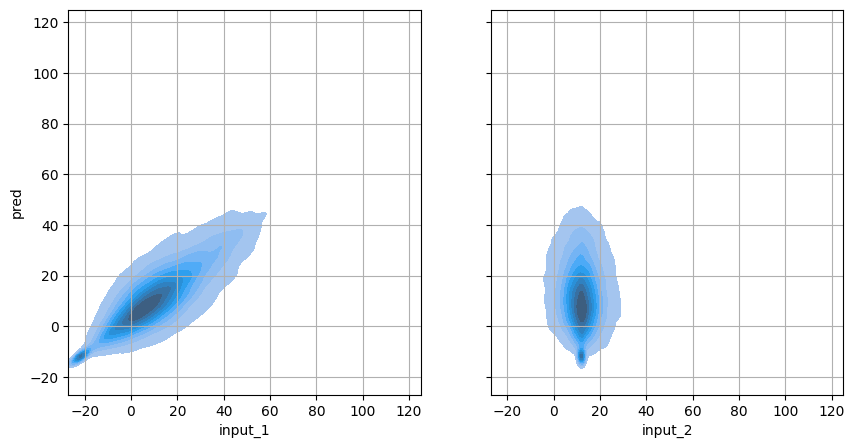

In [112]:
# dimension reduction
x_de = dim_reduct(x)
y_de = dim_reduct(y)
r_de = np.repeat(road[:,np.newaxis], 84, axis=1).transpose().reshape(-1)
# KDE between x and y
df = pd.DataFrame(data=np.stack((x_de[:,0],x_de[:,1], y_de[:,0], r_de), axis=1), columns=["input_1","input_2","pred","id"])
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.kdeplot(
    data=df, x="input_1", y="pred", 
#     hue="id", 
    fill=True,
    ax = axes[0]
)
sns.kdeplot(
    data=df, x="input_2", y="pred", 
#     hue="id", 
    fill=True,
    ax = axes[1]
)
for ax in axes:
    ax.set_xlim(-27,125)
    ax.set_ylim(-27,125)
    ax.grid()
plt.savefig(f"./fig/kde_{city}_{d}.png", bbox_inches="tight")
plt.show()

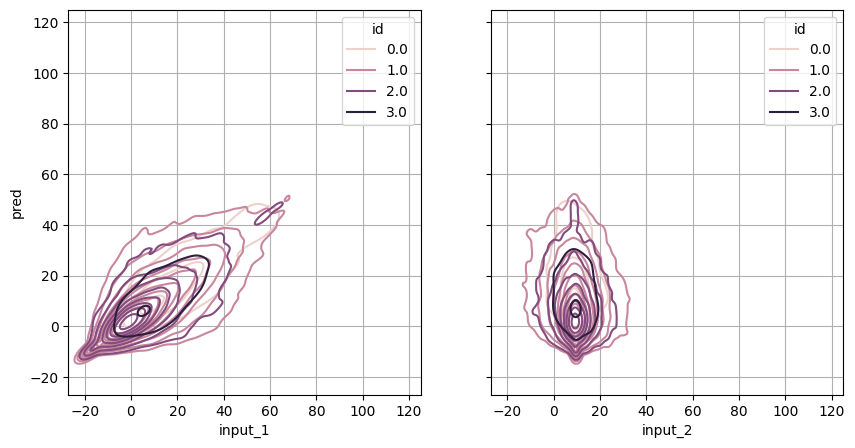

In [118]:
# dimension reduction
x_de = dim_reduct(x)
y_de = dim_reduct(y)
r_de = np.repeat(road[:,np.newaxis], 84, axis=1).transpose().reshape(-1)
# KDE between x and y
df = pd.DataFrame(data=np.stack((x_de[:,0],x_de[:,1], y_de[:,0], r_de), axis=1), columns=["input_1","input_2","pred","id"])
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,5))
sns.kdeplot(
    data=df, x="input_1", y="pred", 
    hue="id", 
    fill=False,
    ax = axes[0]
)
sns.kdeplot(
    data=df, x="input_2", y="pred", 
    hue="id", 
    fill=False,
    ax = axes[1]
)
for ax in axes:
    ax.set_xlim(-27,125)
    ax.set_ylim(-27,125)
    ax.grid()
plt.savefig(f"./fig/kde_{city}_{d}_hue.png", bbox_inches="tight")
plt.show()